In [4]:
import sys
from pathlib import Path

# Add project root so `src` becomes importable
project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print("Added project root to sys.path:", project_root)

Added project root to sys.path: /Users/charlesowen/Documents/1. DL Project/mamba-optical-spectra


In [5]:
from pathlib import Path
import json
import numpy as np

import torch
import torch.nn as nn

from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt

from src.data.datasets import get_dataloaders, get_class_mapping
from src.models.cnn_1d import SpectraCNN


In [6]:
data_dir = Path("../data/processed")  # adjust if your notebook root differs

loaders = get_dataloaders(
    data_dir=data_dir,
    batch_size=128,
    num_workers=0,
    normalize=True,
    pin_memory=False,
)

test_loader = loaders["test"]

class_map = get_class_mapping(data_dir)
class_map


{0: 'stable_single_mode',
 1: 'mode_hop',
 2: 'clipped',
 3: 'high_noise',
 4: 'multi_mode'}

In [7]:
device = torch.device("cpu")  # for notebook/demo; training used mps

checkpoint_path = Path("../experiments/logs/cnn/best_cnn.pt")
assert checkpoint_path.exists(), f"Checkpoint not found at {checkpoint_path}"

checkpoint = torch.load(checkpoint_path, map_location=device)

checkpoint.keys()


dict_keys(['model_state_dict', 'optimizer_state_dict', 'epoch', 'val_loss', 'val_acc', 'class_mapping'])

In [8]:
num_classes = len(class_map)
model = SpectraCNN(num_classes=num_classes)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()

print(f"Loaded model from {checkpoint_path}")
print(f"Trained to epoch: {checkpoint['epoch']}")
print(f"Best val acc recorded: {checkpoint['val_acc'] * 100:.2f}%")


Loaded model from ../experiments/logs/cnn/best_cnn.pt
Trained to epoch: 4
Best val acc recorded: 91.53%


In [9]:
criterion = nn.CrossEntropyLoss()

all_targets = []
all_preds = []
test_loss = 0.0
total = 0

with torch.inference_mode():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)

        total += targets.size(0)
        all_targets.append(targets.cpu().numpy())
        all_preds.append(predicted.cpu().numpy())

test_loss /= total
all_targets = np.concatenate(all_targets)
all_preds = np.concatenate(all_preds)

test_acc = (all_preds == all_targets).mean()

print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc * 100:.2f}%")


Test loss: 0.3376
Test accuracy: 90.33%


In [10]:
cm = confusion_matrix(all_targets, all_preds)
cm


array([[275,   0,  34,   0,   0],
       [  0, 279,   0,   0,  24],
       [ 16,   0, 256,   0,   0],
       [  0,   0,   0, 316,   0],
       [ 19,  38,  14,   0, 229]])

In [11]:
# Ensure a consistent order of classes
num_classes = len(class_map)
idx_to_name = [class_map[i] for i in range(num_classes)]

print("Class index to name mapping:")
for i, name in enumerate(idx_to_name):
    print(f"{i}: {name}")


Class index to name mapping:
0: stable_single_mode
1: mode_hop
2: clipped
3: high_noise
4: multi_mode


In [12]:
report = classification_report(all_targets, all_preds, target_names=idx_to_name)
print(report)


                    precision    recall  f1-score   support

stable_single_mode       0.89      0.89      0.89       309
          mode_hop       0.88      0.92      0.90       303
           clipped       0.84      0.94      0.89       272
        high_noise       1.00      1.00      1.00       316
        multi_mode       0.91      0.76      0.83       300

          accuracy                           0.90      1500
         macro avg       0.90      0.90      0.90      1500
      weighted avg       0.90      0.90      0.90      1500



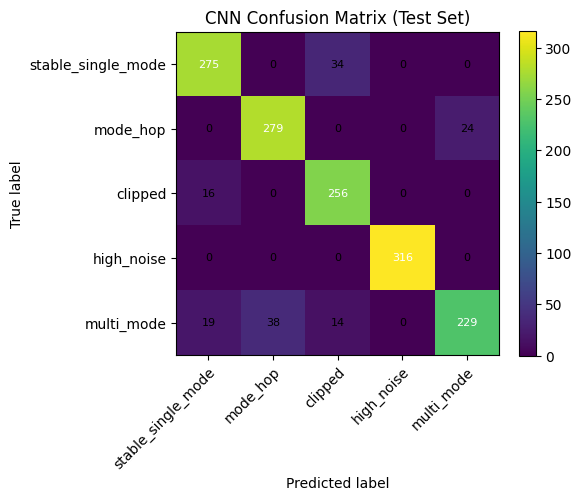

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))

im = ax.imshow(cm, interpolation="nearest")
ax.figure.colorbar(im, ax=ax)

ax.set(
    xticks=np.arange(num_classes),
    yticks=np.arange(num_classes),
    xticklabels=idx_to_name,
    yticklabels=idx_to_name,
    ylabel="True label",
    xlabel="Predicted label",
    title="CNN Confusion Matrix (Test Set)",
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Annotate cells
thresh = cm.max() / 2.0
for i in range(num_classes):
    for j in range(num_classes):
        ax.text(
            j,
            i,
            cm[i, j],
            ha="center",
            va="center",
            color="white" if cm[i, j] > thresh else "black",
            fontsize=8,
        )

fig.tight_layout()
plt.show()


In [14]:
fig_dir = Path("../reports/figures")
fig_dir.mkdir(parents=True, exist_ok=True)

confmat_path = fig_dir / "cnn_confusion_matrix.png"
fig.savefig(confmat_path, dpi=200, bbox_inches="tight")

confmat_path


PosixPath('../reports/figures/cnn_confusion_matrix.png')

In [15]:
metrics = {
    "model": "SpectraCNN",
    "checkpoint_path": str(checkpoint_path),
    "epoch": int(checkpoint["epoch"]),
    "val_acc": float(checkpoint["val_acc"]),
    "test_acc": float(test_acc),
    "test_loss": float(test_loss),
    "class_mapping": class_map,
}

metrics_dir = Path("../experiments/logs/cnn")
metrics_dir.mkdir(parents=True, exist_ok=True)
metrics_path = metrics_dir / "cnn_test_metrics.json"

with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2)

metrics_path


PosixPath('../experiments/logs/cnn/cnn_test_metrics.json')